# **Olympic Medal Prediction**

## Importing Libraries


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

import tensorflow as tf
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

## Reading Dataset

In [2]:
data = pd.read_csv('/content/athlete_events.csv')

In [3]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,570,Pedro Abreu Pascal,M,23.0,200.0,88.0,Cuba,CUB,1980 Summer,1980,Summer,Moskva,Basketball,Basketball Men's Basketball,NaN
1019,571,Rubn Abreu Rivero,M,24.0,177.0,71.0,Venezuela,VEN,1996 Summer,1996,Summer,Atlanta,Cycling,"Cycling Men's Road Race, Individual",NaN
1020,572,Rui Pinto de Abreu,M,15.0,177.0,64.0,Portugal,POR,1976 Summer,1976,Summer,Montreal,Swimming,Swimming Men's 400 metres Freestyle,NaN
1021,572,Rui Pinto de Abreu,M,15.0,177.0,64.0,Portugal,POR,1976 Summer,1976,Summer,Montreal,Swimming,Swimming Men's 4 x 200 metres Freestyle Relay,NaN


In [4]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1023 non-null   int64  
 1   Name    1023 non-null   object 
 2   Sex     1023 non-null   object 
 3   Age     959 non-null    float64
 4   Height  773 non-null    float64
 5   Weight  776 non-null    float64
 6   Team    1023 non-null   object 
 7   NOC     1023 non-null   object 
 8   Games   1023 non-null   object 
 9   Year    1023 non-null   int64  
 10  Season  1023 non-null   object 
 11  City    1023 non-null   object 
 12  Sport   1023 non-null   object 
 13  Event   1023 non-null   object 
 14  Medal   112 non-null    object 
dtypes: float64(3), int64(2), object(10)
memory usage: 120.0+ KB


In [5]:
data.shape

(1023, 15)

In [6]:
data['Medal'].value_counts()

Gold      45
Bronze    34
Silver    33
Name: Medal, dtype: int64

In [7]:
data['Team'].value_counts()

Egypt            189
Norway            59
United States     41
Finland           34
Spain             27
                ... 
Mali               1
Slovenia           1
Venezuela          1
Niger              1
Comoros            1
Name: Team, Length: 115, dtype: int64

## Exploratory Data Analysis

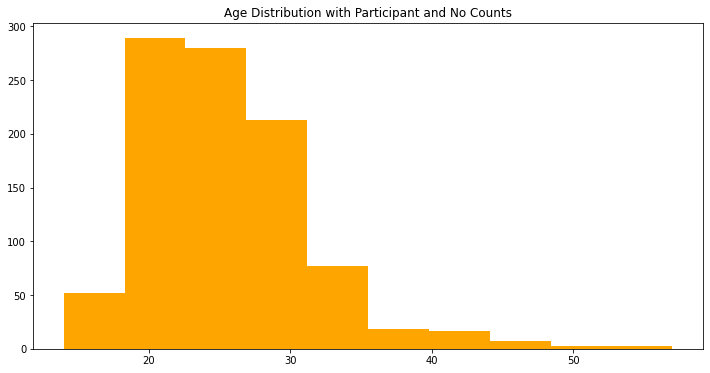

In [8]:
# Age Distribution

plt.figure(figsize=(12,6))
plt.title("Age Distribution with Participant and No Counts")
plt.hist(data.Age,color='orange')
plt.show()

Athletes over the age of 20 to 30 is majority age group participant


In [9]:
# Gender DIstribution
gender_unique_values = data.Sex.value_counts()
gender_unique_values

M    857
F    166
Name: Sex, dtype: int64

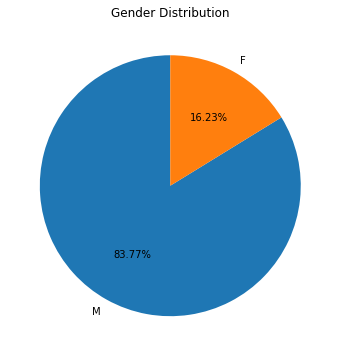

In [10]:
plt.figure(figsize=(12,6))
plt.title("Gender Distribution")
plt.pie(gender_unique_values, labels=gender_unique_values.index, autopct="%.2f%%", startangle=90)
plt.show()

Male participants are more than female partocipants in the olympic

In [11]:
# Check how many female participants in each year in summer season

femal_partici_p = data[(data.Sex=='F') & (data.Season == 'Summer')][['Sex', 'Year']]
femal_partici_p = femal_partici_p.groupby('Year').count().reset_index()
femal_partici_p

,Year,Sex
0,1900,2
1,1932,2
2,1948,1
3,1956,2
4,1960,5
5,1964,1
6,1972,6
7,1976,1
8,1980,3
9,1984,7


Text(0, 0.5, 'Female Participants')

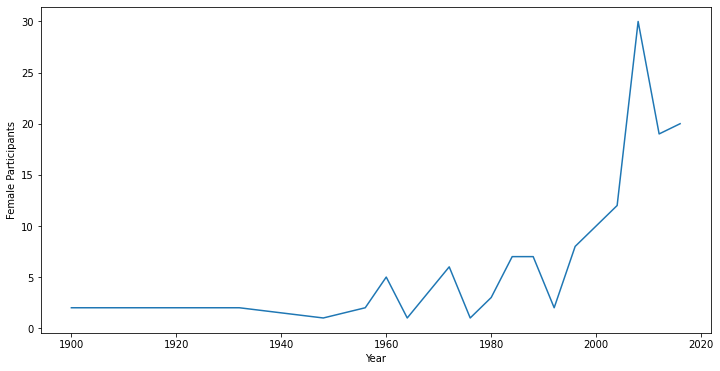

In [12]:
plt.figure(figsize=(12,6))
sns.lineplot(data=femal_partici_p, x='Year', y='Sex')
plt.xlabel('Year')
plt.ylabel('Female Participants')

Female participant gradually increases at high level since year 2000

In [13]:
# Participants accros the season

seasons = data.Season.value_counts()
seasons

Summer    874
Winter    149
Name: Season, dtype: int64

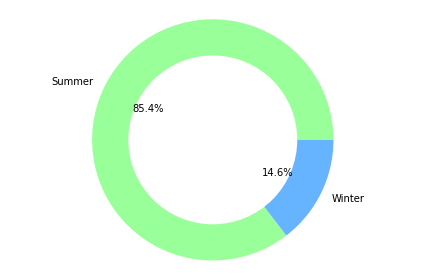

In [14]:
fig1, ax1 = plt.subplots()

colors = ['#99ff99','#66b3ff']

ax1.pie(seasons, colors = colors, labels=seasons.index, autopct='%1.1f%%')

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

Athletes among summer season are more than in winter season

In [15]:
# Top Countries Participating in Olympics
top_countries = data.Team.value_counts().sort_values(ascending=False).head(15)
top_countries

Egypt                   189
Norway                   59
United States            41
Finland                  34
Spain                    27
Japan                    27
Iraq                     25
Russia                   24
United Arab Republic     21
Italy                    21
Sweden                   19
Netherlands              19
Portugal                 18
Canada                   17
Great Britain            17
Name: Team, dtype: int64

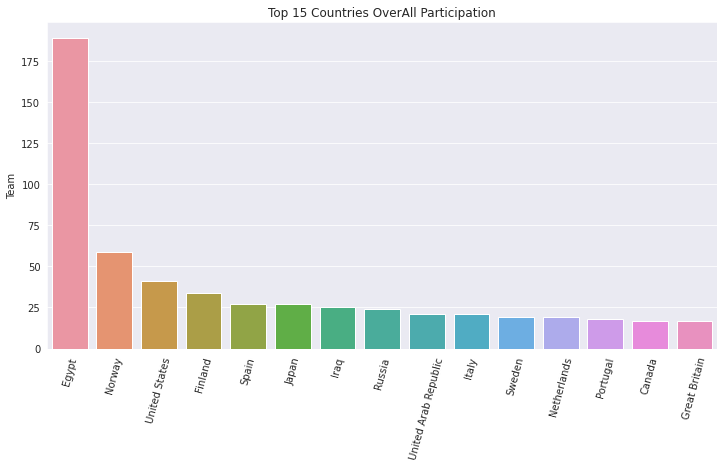

In [16]:
# EDA with Data Visualization
sns.set_style('darkgrid')
plt.figure(figsize=(12, 6))
plt.title('Top 15 Countries OverAll Participation')
plt.xticks(rotation=75)
sns.barplot(x=top_countries.index, y=top_countries)

In [17]:
# Countries which won the maximum Gold Medals in olympic

max_year_country = data[(data.Medal == 'Gold')].Team
max_year_country = max_year_country.value_counts().head(20)
max_year_country


Italy               7
Norway              7
United States       4
France              4
Finland             3
Spain               3
Vesper Boat Club    2
Bulgaria            1
Azerbaijan          1
Belarus             1
Cameroon            1
Uzbekistan          1
Unified Team        1
Japan               1
Pakistan            1
Ethiopia            1
Taifun              1
Denmark/Sweden      1
Great Britain       1
Soviet Union        1
Name: Team, dtype: int64

Text(0.5, 0, 'Top 20 Gold Medal Won Countrywise')

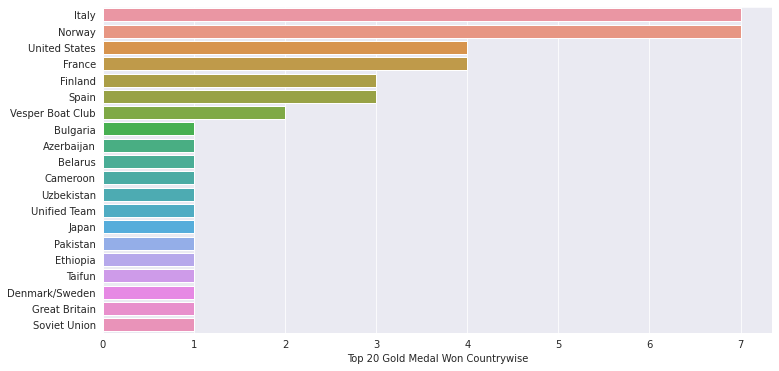

In [18]:
plt.figure(figsize=(12,6))
sns.barplot(x=max_year_country, y=max_year_country.index)
plt.xlabel("Top 20 Gold Medal Won Countrywise")

Text(0, 0.5, 'Height')

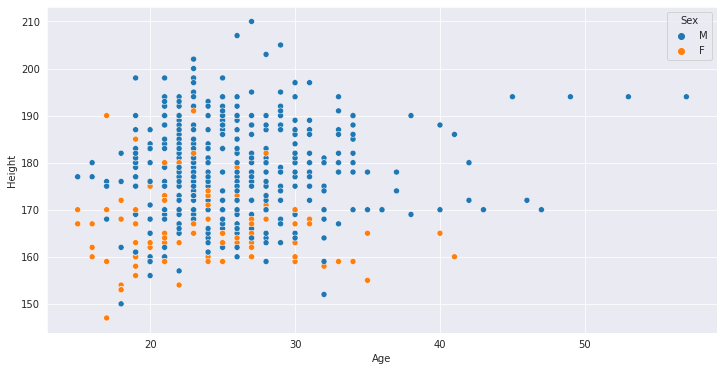

In [19]:
# Age vs Height Spread

age_heig = data[(data.Age != 0) & (data.Height != 0.0) & (data.Medal != 'None') & (data.Season == 'Summer')]
plt.figure(figsize=(12,6))
sns.scatterplot(x=age_heig.Age, y=age_heig.Height, data=age_heig, hue='Sex')
plt.xlabel('Age')
plt.ylabel('Height')

Text(0, 0.5, 'Weight')

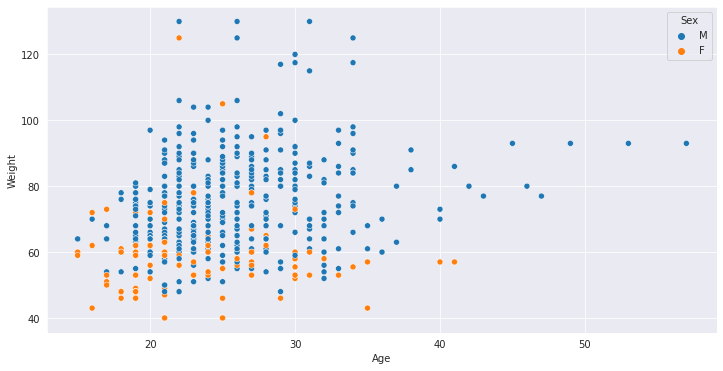

In [20]:
# Age vs Weight Spread

age_weig = data[(data.Age != 0.0) & (data.Weight != 0.0) & (data.Medal != 'None') & (data.Season == 'Summer')]
plt.figure(figsize=(12,6))
sns.scatterplot(x=age_weig.Age, y=age_weig.Weight, data=age_weig, hue='Sex')
plt.xlabel('Age')
plt.ylabel('Weight')


Text(0, 0.5, 'Height')

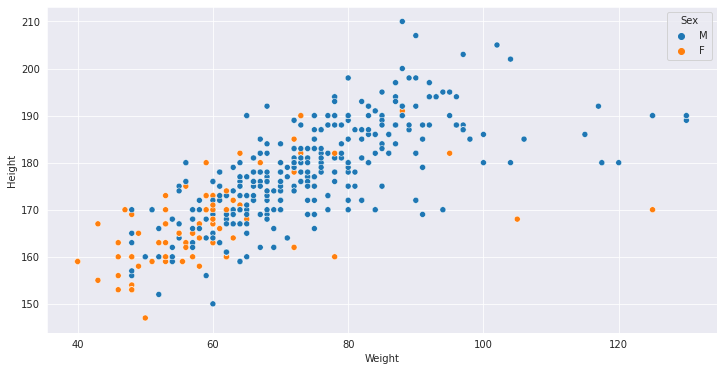

In [21]:
# Weight & Height Spread

heig_weight = data[(data.Height != 0.0) & (data.Age != 0) & (data.Weight != 0.0) & (data.Medal != 'None') & (data.Season == 'Summer')]
plt.figure(figsize=(12,6))
sns.scatterplot(x=heig_weight.Weight, y=heig_weight.Height, data=heig_weight, hue='Sex')
plt.xlabel('Weight')
plt.ylabel('Height')

## Data Cleaning

In [22]:
# To fill missing values in Medal column
data['Medal'] = data['Medal'].apply(lambda x: 1 if str(x) != 'nan' else 0)


In [23]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,0
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,570,Pedro Abreu Pascal,M,23.0,200.0,88.0,Cuba,CUB,1980 Summer,1980,Summer,Moskva,Basketball,Basketball Men's Basketball,0
1019,571,Rubn Abreu Rivero,M,24.0,177.0,71.0,Venezuela,VEN,1996 Summer,1996,Summer,Atlanta,Cycling,"Cycling Men's Road Race, Individual",0
1020,572,Rui Pinto de Abreu,M,15.0,177.0,64.0,Portugal,POR,1976 Summer,1976,Summer,Montreal,Swimming,Swimming Men's 400 metres Freestyle,0
1021,572,Rui Pinto de Abreu,M,15.0,177.0,64.0,Portugal,POR,1976 Summer,1976,Summer,Montreal,Swimming,Swimming Men's 4 x 200 metres Freestyle Relay,0


In [24]:
# Drop Uncessary columns
data = data.drop(['ID', 'Name', 'Games'], axis=1)

In [25]:
# Checking null values in the data 
data.isna().mean()


Sex       0.000000
Age       0.062561
Height    0.244379
Weight    0.241447
Team      0.000000
NOC       0.000000
Year      0.000000
Season    0.000000
City      0.000000
Sport     0.000000
Event     0.000000
Medal     0.000000
dtype: float64

In [26]:
data.groupby(['Medal', 'Sex']).mean().astype(np.int)

Age  Height  Weight  Year
Medal Sex                           
0     F     23     166      60  1997
      M     25     177      73  1980
1     F     21     169      60  1989
      M     25     179      79  1974

In [27]:
# Fill null values with mean values for these columns
for column in ['Age', 'Height', 'Weight']:
    data[column] = data.groupby(['Medal', 'Sex'])[column].apply(lambda x: x.fillna(x.mean()).astype(np.int))

In [28]:
print("Total missing values:", data.isna().sum().sum())


Total missing values: 0


In [29]:
data

,Sex,Age,Height,Weight,Team,NOC,Year,Season,City,Sport,Event,Medal
0,M,24,180,80,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,0
1,M,23,170,60,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,0
2,M,24,177,73,Denmark,DEN,1920,Summer,Antwerpen,Football,Football Men's Football,0
3,M,34,179,79,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,1
4,F,21,185,82,Netherlands,NED,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1018,M,23,200,88,Cuba,CUB,1980,Summer,Moskva,Basketball,Basketball Men's Basketball,0
1019,M,24,177,71,Venezuela,VEN,1996,Summer,Atlanta,Cycling,"Cycling Men's Road Race, Individual",0
1020,M,15,177,64,Portugal,POR,1976,Summer,Montreal,Swimming,Swimming Men's 400 metres Freestyle,0
1021,M,15,177,64,Portugal,POR,1976,Summer,Montreal,Swimming,Swimming Men's 4 x 200 metres Freestyle Relay,0


In [30]:
# Checking no of unique values in the column
{column: len(data[column].unique()) for column in data.select_dtypes('object').columns}

{'City': 41,
 'Event': 272,
 'NOC': 106,
 'Season': 2,
 'Sex': 2,
 'Sport': 47,
 'Team': 115}

In [31]:
def binary_encode(df, columns, positive_values):
    df = df.copy()
    for column, positive_value in zip(columns, positive_values):
        df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [32]:
data = binary_encode(
    data,
    columns=['Sex', 'Season'],
    positive_values=['M', 'Summer']
)

data = onehot_encode(
    data,
    columns=['Team', 'NOC', 'City', 'Sport', 'Event'],
    prefixes=['T', 'N', 'C', 'S', 'E']
)

In [33]:
data

,Sex,Age,Height,Weight,Year,Season,Medal,T_Afghanistan,T_Algeria,T_Angola,T_Argentina,T_Armenia,T_Australia,T_Azerbaijan,T_Bahrain,T_Belarus,T_Belgium,T_Benin,T_Brazil,T_Brunei,T_Bulgaria,T_Cameroon,T_Canada,T_Chad,T_Chile,T_China,T_Comoros,T_Congo (Brazzaville),T_Costa Rica,T_Cote d'Ivoire,T_Croatia,T_Cuba,T_Denmark,T_Denmark/Sweden,T_Djibouti,T_East Germany,T_Egypt,T_Eritrea,T_Estonia,T_Ethiopia,...,E_Taekwondo Women's Featherweight,E_Taekwondo Women's Flyweight,E_Taekwondo Women's Heavyweight,E_Tennis Men's Doubles,E_Tennis Men's Singles,E_Trampolining Men's Individual,E_Tug-Of-War Men's Tug-Of-War,E_Volleyball Men's Volleyball,E_Volleyball Women's Volleyball,E_Water Polo Men's Water Polo,E_Water Polo Women's Water Polo,E_Weightlifting Men's Featherweight,E_Weightlifting Men's Flyweight,E_Weightlifting Men's Heavyweight,E_Weightlifting Men's Light-Heavyweight,E_Weightlifting Men's Lightweight,E_Weightlifting Men's Middle-Heavyweight,E_Weightlifting Men's Middleweight,E_Weightlifting Women's Featherweight,E_Weightlifting Women's Heavyweight,E_Weightlifting Women's Light-Heavyweight,E_Weightlifting Women's Lightweight,E_Weightlifting Women's Super-Heavyweight,"E_Wrestling Men's Bantamweight, Freestyle","E_Wrestling Men's Bantamweight, Greco-Roman","E_Wrestling Men's Featherweight, Freestyle","E_Wrestling Men's Flyweight, Freestyle","E_Wrestling Men's Flyweight, Greco-Roman","E_Wrestling Men's Heavyweight, Freestyle","E_Wrestling Men's Heavyweight, Greco-Roman","E_Wrestling Men's Light-Heavyweight, Freestyle","E_Wrestling Men's Light-Heavyweight, Greco-Roman","E_Wrestling Men's Lightweight, Freestyle","E_Wrestling Men's Lightweight, Greco-Roman","E_Wrestling Men's Middleweight A, Greco-Roman","E_Wrestling Men's Middleweight, Freestyle","E_Wrestling Men's Middleweight, Greco-Roman","E_Wrestling Men's Super-Heavyweight, Greco-Roman","E_Wrestling Men's Welterweight, Freestyle","E_Wrestling Men's Welterweight, Greco-Roman"
0,1,24,180,80,1992,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,23,170,60,2012,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,24,177,73,1920,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,34,179,79,1900,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,21,185,82,1988,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,1,23,200,88,1980,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1019,1,24,177,71,1996,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1020,1,15,177,64,1976,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1021,1,15,177,64,1976,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# Spilt data in target column and features columns
y = data['Medal']
X = data.drop('Medal', axis=1)

## Feature Selection

In [35]:
#Apply SelectKBest and extract top 10 features
best=SelectKBest(score_func=chi2, k=10)

In [36]:
fit=best.fit(X,y)


In [37]:
data_scores=pd.DataFrame(fit.scores_)
data_columns=pd.DataFrame(X.columns)

In [38]:
#Join the two dataframes
scores=pd.concat([data_columns,data_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(11,'Score'))


                                             Feature      Score
3                                             Weight  37.606077
56                                           T_Italy  36.976169
172                                            N_ITA  36.976169
476                       E_Rowing Men's Coxed Pairs  33.664149
49                                         T_Hungary  32.245193
164                                            N_HUN  32.245193
319                    E_Alpine Skiing Men's Super G  24.453160
449  E_Gymnastics Men's Team All-Around, Free System  24.401786
298                                         S_Rowing  22.201309
35                                           T_Egypt  21.044390
148                                            N_EGY  21.044390


In [39]:
#Select 10 features
features=scores["Feature"].tolist()[:10]
features

['Sex',
 'Age',
 'Height',
 'Weight',
 'Year',
 'Season',
 'T_Afghanistan',
 'T_Algeria',
 'T_Angola',
 'T_Argentina']

## Make new dataset with cleaned data

In [40]:
data=data[['Age','Sex','Height','Weight','Year','Season','T_Afghanistan','T_Algeria','T_Angola','T_Argentina','Medal']]
data.head()

,Age,Sex,Height,Weight,Year,Season,T_Afghanistan,T_Algeria,T_Angola,T_Argentina,Medal
0,24,1,180,80,1992,1,0,0,0,0,0
1,23,1,170,60,2012,1,0,0,0,0,0
2,24,1,177,73,1920,1,0,0,0,0,0
3,34,1,179,79,1900,1,0,0,0,0,1
4,21,0,185,82,1988,0,0,0,0,0,0


In [41]:
y = data['Medal']
X = data.drop(['Medal'], axis=1)

#Split data into training and testing data
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.4, random_state=1)


## Feature Scaling

In [42]:
# Scaling data 
scaler = MinMaxScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

## Predictive Modeling

In [43]:
m1 = 'LogisticRegression'
lr = LogisticRegression(random_state=1, max_iter=1000)
lr.fit(train_x, train_y)
lr_predict = lr.predict(test_x)
lr_conf_matrix = confusion_matrix(test_y, lr_predict)
lr_acc_score = accuracy_score(test_y, lr_predict)
print("confusion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(test_y,lr_predict))

confusion matrix
[[359   0]
 [ 51   0]]


Accuracy of Logistic Regression: 87.5609756097561 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       359
           1       0.00      0.00      0.00        51

    accuracy                           0.88       410
   macro avg       0.44      0.50      0.47       410
weighted avg       0.77      0.88      0.82       410



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [44]:
m2 = 'MultinomialNB'
nv = MultinomialNB()
nv.fit(train_x, train_y)
nv_predict = nv.predict(test_x)
nv_conf_matrix = confusion_matrix(test_y, nv_predict)
nv_acc_score = accuracy_score(test_y, nv_predict)
print("confusion matrix")
print(nv_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",nv_acc_score*100,'\n')
print(classification_report(test_y,nv_predict))

confusion matrix
[[359   0]
 [ 51   0]]


Accuracy of Logistic Regression: 87.5609756097561 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       359
           1       0.00      0.00      0.00        51

    accuracy                           0.88       410
   macro avg       0.44      0.50      0.47       410
weighted avg       0.77      0.88      0.82       410



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
m3 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 30)
dt.fit(train_x,train_y)
dt_predicted = dt.predict(test_x)
dt_conf_matrix = confusion_matrix(test_y, dt_predicted)
dt_acc_score = accuracy_score(test_y, dt_predicted)
print("confusion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(test_y,dt_predicted))

confusion matrix
[[339  20]
 [ 32  19]]


Accuracy of DecisionTreeClassifier: 87.3170731707317 

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       359
           1       0.49      0.37      0.42        51

    accuracy                           0.87       410
   macro avg       0.70      0.66      0.68       410
weighted avg       0.86      0.87      0.87       410



In [46]:
m4 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=12)
rf.fit(train_x,train_y)
rf_predicted = rf.predict(test_x)
rf_conf_matrix = confusion_matrix(test_y, rf_predicted)
rf_acc_score = accuracy_score(test_y, rf_predicted)
print("confusion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(test_y,rf_predicted))

confusion matrix
[[351   8]
 [ 37  14]]


Accuracy of Random Forest: 89.02439024390245 

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       359
           1       0.64      0.27      0.38        51

    accuracy                           0.89       410
   macro avg       0.77      0.63      0.66       410
weighted avg       0.87      0.89      0.87       410



In [47]:
m5 = 'Gradient Boosting Classifier'
gvc =  GradientBoostingClassifier()
gvc.fit(train_x,train_y)
gvc_predicted = gvc.predict(test_x)
gvc_conf_matrix = confusion_matrix(test_y, gvc_predicted)
gvc_acc_score = accuracy_score(test_y, gvc_predicted)
print("confusion matrix")
print(gvc_conf_matrix)
print("\n")
print("Accuracy of Gradient Boosting Classifier:",gvc_acc_score*100,'\n')
print(classification_report(test_y,gvc_predicted))

confusion matrix
[[350   9]
 [ 38  13]]


Accuracy of Gradient Boosting Classifier: 88.53658536585365 

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       359
           1       0.59      0.25      0.36        51

    accuracy                           0.89       410
   macro avg       0.75      0.61      0.65       410
weighted avg       0.86      0.89      0.86       410



In [48]:
m6 = 'Neural Network'
inputs = tf.keras.Input(shape=(X.shape[1]))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)


history = model.fit(
    train_x,
    train_y,
    validation_split=0.2,
    batch_size=32,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
16/16 [==============================] - 1s 20ms/step - loss: 0.6494 - accuracy: 0.6571 - auc: 0.4682 - val_loss: 0.5012 - val_accuracy: 0.9187 - val_auc: 0.5655
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4408 - accuracy: 0.8959 - auc: 0.4614 - val_loss: 0.3382 - val_accuracy: 0.9187 - val_auc: 0.5726
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3488 - accuracy: 0.8959 - auc: 0.4855 - val_loss: 0.2955 - val_accuracy: 0.9187 - val_auc: 0.5668
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3422 - accuracy: 0.8959 - auc: 0.4726 - val_loss: 0.2924 - val_accuracy: 0.9187 - val_auc: 0.5726
Epoch 5/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3410 - accuracy: 0.8959 - auc: 0.4646 - val_loss: 0.2915 - val_accuracy: 0.9187 - val_auc: 0.5889
Epoch 6/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3385 - accuracy: 0.8959 - auc: 0.4891 - val_loss: 0.2931 - 

In [49]:
model.evaluate(test_x, test_y)

13/13 [==============================] - 0s 1ms/step - loss: 0.3665 - accuracy: 0.8756 - auc: 0.6198


[0.3665231466293335, 0.8756097555160522, 0.6198045015335083]

In [50]:
y_true = np.array(test_y)
y_pred = np.squeeze(np.array(model.predict(test_x) >= 0.5, dtype=np.int))

In [51]:
nn_conf_matrix = confusion_matrix(y_true, y_pred)
nn_acc_score = accuracy_score(y_true, y_pred)
print("confusion matrix")
print(gvc_conf_matrix)
print("\n")
print("Accuracy of Neural Network:",nn_acc_score*100,'\n')
print(classification_report(y_true, y_pred))

confusion matrix
[[350   9]
 [ 38  13]]


Accuracy of Neural Network: 87.5609756097561 

              precision    recall  f1-score   support

           0       0.88      1.00      0.93       359
           1       0.00      0.00      0.00        51

    accuracy                           0.88       410
   macro avg       0.44      0.50      0.47       410
weighted avg       0.77      0.88      0.82       410



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Model Evaluation

In [52]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','MultinomialNB','Decision Tree','Random Forest',
                                  'Gradient Boosting','Neural Network'], 
                         'Accuracy': [lr_acc_score*100, nv_acc_score*100, dt_acc_score*100, rf_acc_score*100,gvc_acc_score*100,
                                      nn_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,87.560976
1,MultinomialNB,87.560976
2,Decision Tree,87.317073
3,Random Forest,89.024390
4,Gradient Boosting,88.536585
5,Neural Network,87.560976


## Final Random Forest Classifier Model


In [53]:
model = RandomForestClassifier(n_estimators=200, random_state=0,max_depth=12)
model.fit(train_x,train_y)
predicted = model.predict(test_x)
accuracy = accuracy_score(test_y, rf_predicted)
print("Accuracy of Random Forest:",accuracy*100,'\n')


Accuracy of Random Forest: 89.02439024390245 



## Conclusion
Random Forest Classifier Model performs best among all models